# Data description 


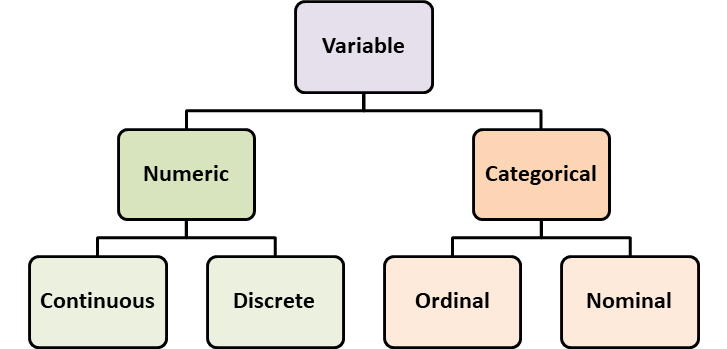

# Objective

*   Get an initial understanding of the data, such as quantity, types of variables, volume of missing data, etc.
*   Expected output is a dataset with no null values ​​and a descriptive analysis of numeric and categorical attributes




# 1. Library imports

*   Pandas: responsible for data manipulation/analysis through the dataframe format
*   numpy: used for working with arrays. It also has functions for working in domain of linear algebra, fourier transform, and matrices.
*   math: provides access to the mathematical functions
*   inflection : string transformation library. It singularizes and pluralizes English words
*   matplotlib: provides an object-oriented API for embedding plots
*   seaborn:  data visualization library

In [ ]:
import math
import numpy as np
import pandas as pd
import inflection
import seaborn as sns
from matplotlib import pyplot as plt

# 2. Loading Data

In [ ]:
#from rossman dataset
df_sales_raw = pd.read_csv( '/content/drive/MyDrive/Colab Notebooks/DS_em_producao/train.csv', low_memory=False )
df_store_raw = pd.read_csv( '/content/drive/MyDrive/Colab Notebooks/DS_em_producao/store.csv', low_memory=False )
# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )


# 3. Data description 

In [ ]:
 df1 = df_raw.copy()

* `Id` - an Id that represents a (Store, Date) duple within the test set
* `Store` - a unique Id for each store
* `Sales` - the turnover for any given day (this is what you are predicting)
* `Customers` - the number of customers on a given day
* `Open` - an indicator for whether the store was open: 0 = closed, 1 = open
* `StateHoliday` - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = * Christmas, 0 = None
* `SchoolHoliday` - indicates if the (Store, Date) was affected by the closure of public schools
* `StoreType` - differentiates between 4 different store models: a, b, c, d
* `Assortment` - describes an assortment level: a = basic, b = extra, c = extended
* `CompetitionDistance` - distance in meters to the nearest competitor store
* `CompetitionOpenSince[Month/Year]` - gives the approximate year and month of the time the nearest competitor was opened
* `Promo` - indicates whether a store is running a promo on that day
* `Promo2` - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* `Promo2Since[Year/Week]` - describes the year and calendar week when the store started participating in Promo2
* `PromoInterval` - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

First, let's transform the columns.

In [ ]:
# Rename Columns

cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open',
'Promo', 'StateHoliday', 'SchoolHoliday',
'StoreType', 'Assortment', 'CompetitionDistance',
'CompetitionOpenSinceMonth',
'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
'Promo2SinceYear', 'PromoInterval']
snakecase = lambda x: inflection.underscore( x )
cols_new = list( map( snakecase, cols_old ) )
# rename
df1.columns = cols_new

In [ ]:
df1.shape

(1017209, 18)

In [ ]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [ ]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

# 4. Fillout NA

**A big issue related to data science is the NaN volume of available data. The main ways to deal with it are:**

*   1 -  You could use "dropna", it's a quick and simple way to remove the missing values. The big problem is data loss, because by deleting the lines we lose other information that can be crucial to solve the problem in question.
*   2 - ML algorithms that make substitution according to column behavior
*   3 - Thinking about the business and raising hypotheses about what could have generated the NA to deal with each scenario from there. **That's the approach I'll take.**



In [ ]:
df1['date'] = df1['date'].astype('datetime64[ns]')

In [ ]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
541232,128,1,2014-03-03,11101,779,1,1,0,0,d,c,2000.0,NaN,NaN,1,1.0,2013.0,"Jan,Apr,Jul,Oct"


In [ ]:
#competition_distance
# Solution: If this column has NA, it may make sense to assume that there is no competitor close enough to be relevant to the target (sales). So, let's put a very high value for the distance.
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )


#The next columns can be empty because it doesn't have a close competitor/promo, or it does and we don't know/was not noted when it happened.
#Solution: if it's na, let's copy the sale date that we have in the line
# even if it doesn't make total sense, just having at least one date can be important to explain the behavior of the sale variable.

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

#Assumption similar to the previous case.
#competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

#promo2_since_week
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan(x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

#promo2_since_year
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )



#promo_interval
#We created dictionary to help us. 
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}


#The null values ​​are replaced by zero and then we check if the store participated in the second promotion

df1['promo_interval'].fillna(0, inplace=True )
df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )


In [ ]:
df1.sample(5).T

,520408,103277,957486,906553,980109
store,489,698,487,844,810
day_of_week,6,4,6,3,7
date,2014-03-22 00:00:00,2015-04-30 00:00:00,2013-02-23 00:00:00,2013-04-10 00:00:00,2013-02-03 00:00:00
sales,2439,25067,5714,4706,0
customers,254,2780,671,542,0
open,1,1,1,1,0
promo,0,1,0,1,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,a,a,d,a,d


In [ ]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [ ]:
#watching data types change
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [ ]:
#change data types

# competiton
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
# promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

# 5. Descriptive statistics

The main objective here is to understand the data using central tendency (mean, median and mode), measures of dispersion (minimum and maximum values, standard deviation and variance, percentiles, quartiles and deciles)

In [ ]:

# separating numeric variables
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )

# separating categories categories
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64','datetime64[ns]'] )

## Numerical Atributes

In [ ]:
# Central Tendency - mean, meadina
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis']


In [ ]:
#Here we can see the difference between the mean and median in each variable. If they are relatively close, we already know that there is no significant shift from the normal represented by the skew.

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


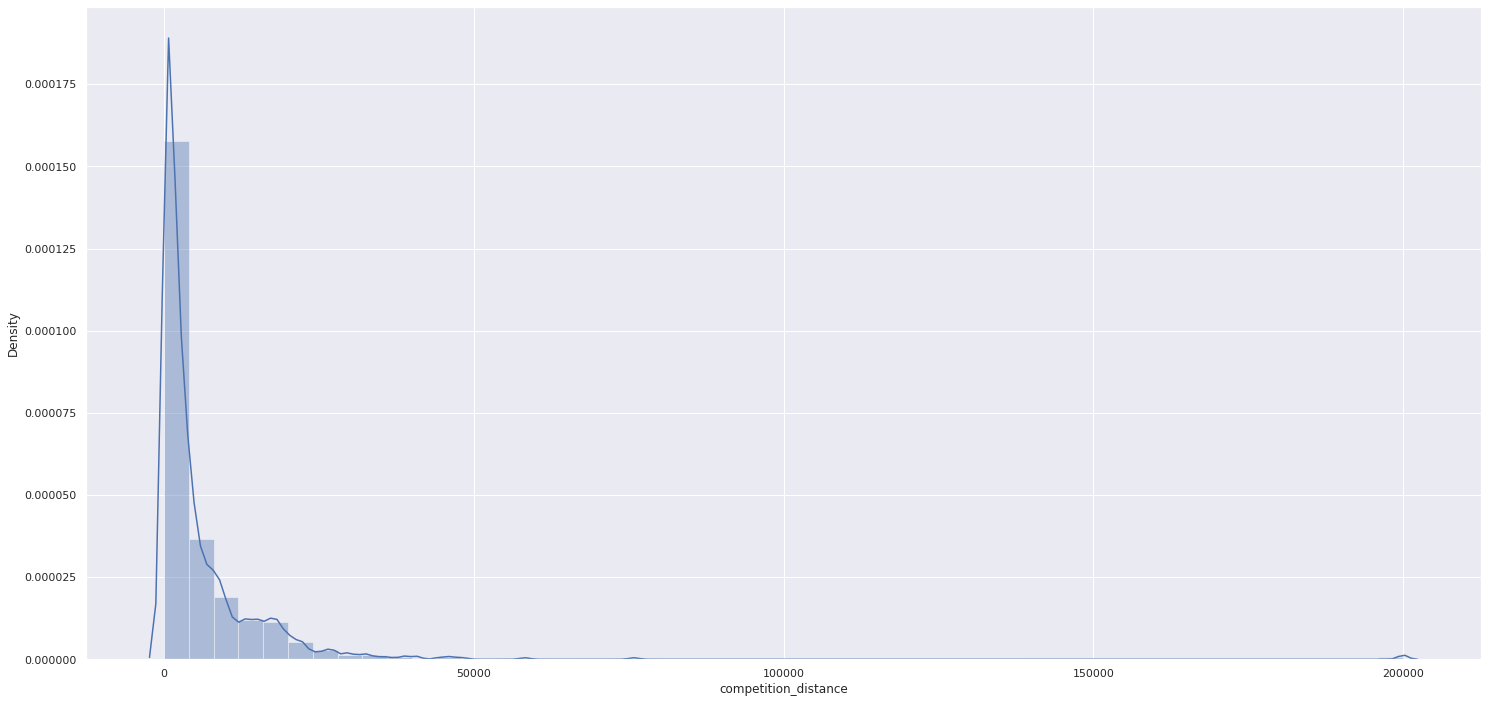

In [ ]:
sns.distplot(df1['competition_distance'])

## Categorical Atributes

From bloxplot we can graphically demonstrating the locality, spread and skewness groups of numerical data through their quartiles

In [ ]:
 cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

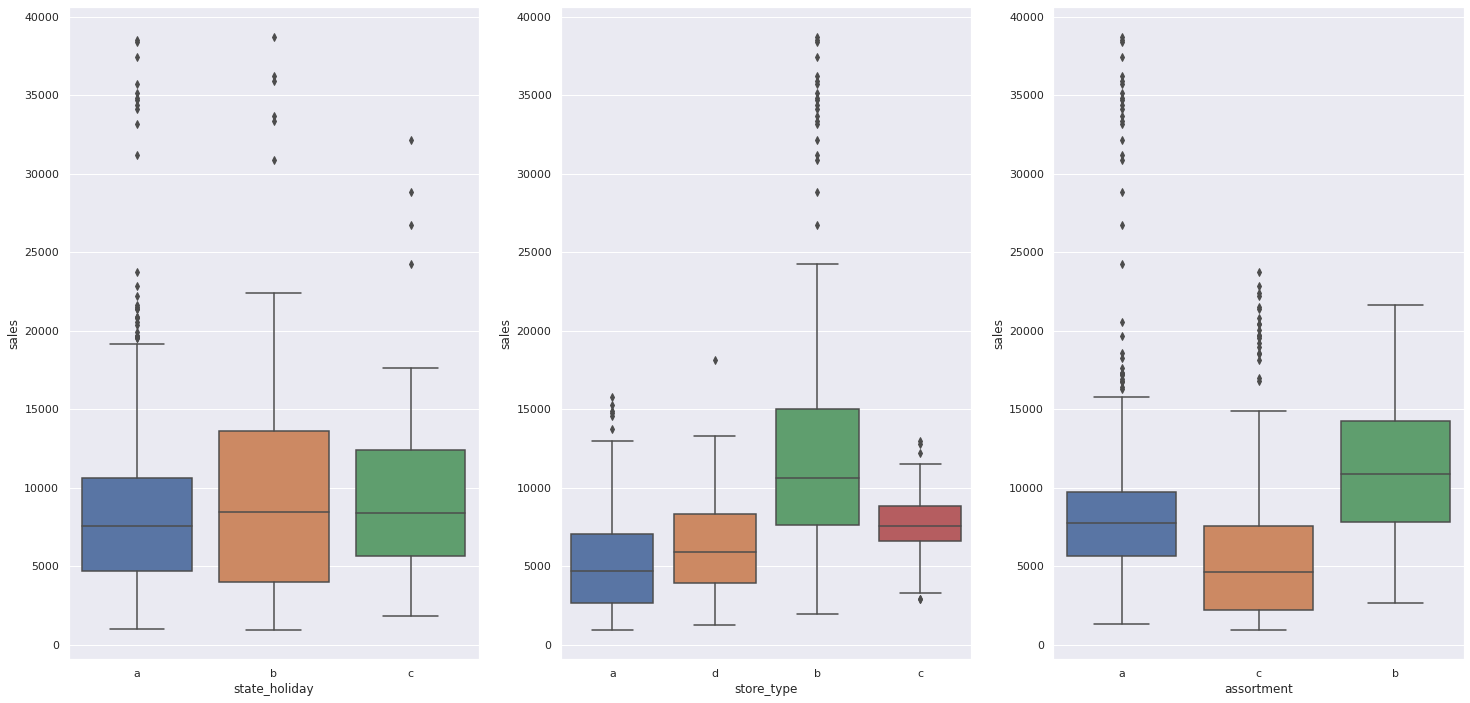

In [ ]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot( 1, 3, 1 ) 
sns.boxplot( x='state_holiday', y='sales', data=aux )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux )
